# Verify correlation results of Pabst et al. (2021)

In [1]:
import numpy as np
import astropy.io.fits as pyfits
import astropy.wcs as wcs

import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from numpy.random import randint

import time

#### To Do
- Read Herrera-Camus, Pabst+21a, Jackson+20, Pineda et al. 2014, De Looze et al. 2014 in detail
- Implement proper rms cutoff
- Note: Orion is not on a grid of 8" (despite the file name)

In [2]:
#### User input ####

## name of the data files
name_CII = '../data/data_FEEDBACK/ORIONA/ORIONA_CII_final_res20_grid8_0p5_clean_integrated.fits'
name_70  = '../data/data_FEEDBACK/ORIONA/ORIONA_Herschel_PACS_70_20_8.fits'
name_8 = '../data/data_FEEDBACK/ORIONA/ORIONA_Spitzer_IRAC_8_20_8.fits'

## Spitzer 8 micron bandwidth
bandwidth_8micron = 1.58e13 ## Hz

## intensity cut off
min_cut_CII = 10.

## size input for the random number selection
sizes = np.logspace(2, 4.5, num = 10)
num_randpoints_plot = 1e4

In [3]:
## open fits files
hdu = pyfits.open(name_CII)
hdu.info()
dataCII = hdu[0].data

hdu = pyfits.open(name_70)
hdu.info()
data70 = hdu[0].data

hdu = pyfits.open(name_8)
hdu.info()
data8 = hdu[0].data

Filename: ../data_FEEDBACK/ORIONA/ORIONA_CII_final_res20_grid8_0p5_clean_integrated.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      36   (1151, 1520)   float32   
Filename: ../data_FEEDBACK/ORIONA/ORIONA_Herschel_PACS_70_20_8.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      36   (1151, 1520)   float64   
Filename: ../data_FEEDBACK/ORIONA/ORIONA_Spitzer_IRAC_8_20_8.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      36   (1151, 1520)   float64   


In [4]:
## remove all nans from map
data70[np.isnan(dataCII)] = np.nan
data8[np.isnan(dataCII)] = np.nan

## prepare data for plotting: convert to the correct units
ravCII = 7.0354e-6 * dataCII.ravel()  ## convert to erg/s/cm^2/sr
min_cut_CII = min_cut_CII * 7.0354e-6
rav70 = data70.ravel()
rav8 = data8.ravel() *2.9*4.8e-5*0.2021/10.4*0.74 ## convert to erg/s/cm^2/sr

print(min_cut_CII)

## remove all nan values
rav8 = rav8[~np.isnan(ravCII)]
rav70 = rav70[~np.isnan(ravCII)]
ravCII = ravCII[~np.isnan(ravCII)]

## cut all values below detection
rav8 = rav8[ravCII > min_cut_CII]
rav70 = rav70[ravCII > min_cut_CII]
ravCII = ravCII[ravCII > min_cut_CII]

## values on log scale
rav8 = np.log10(rav8)
rav70 = np.log10(rav70)
ravCII = np.log10(ravCII)

## create Pandas Dataframe
df = pd.DataFrame({"CII": ravCII, '70 micron': rav70, '8 micron': rav8})
print(df)

## correlations from Pabst+2021
#xFit70_Pabst2021 = [10**(2+i*0.1) for i in range(0,35)]
#yFit70_Pabst2021 = [10**-5.1 * x**0.57 for x in xFit70_Pabst2021]

xFit8_Pabst2021 = [10**(-3+i*0.1) for i in range(0,30)]
yFit8_Pabst2021 = [10**-1.83 * x**0.65 for x in xFit8_Pabst2021]

7.0354e-05
              CII  70 micron  8 micron
0       -4.117184  -1.516643 -2.665608
1       -4.072258  -1.503680 -2.658484
2       -4.055768  -1.489939 -2.650856
3       -4.060623  -1.475604 -2.642773
4       -4.079619  -1.460867 -2.634278
...           ...        ...       ...
1098920 -3.819985  -1.712467 -2.553646
1098921 -3.811923  -1.714925 -2.549300
1098922 -3.803847  -1.716073 -2.545047
1098923 -3.794427  -1.715993 -2.540935
1098924 -3.784938  -1.714861 -2.537007

[1098925 rows x 3 columns]


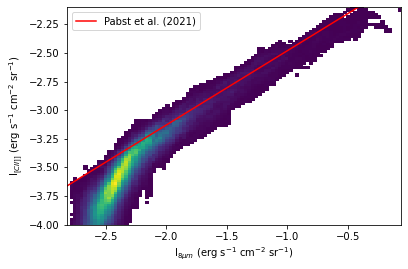

In [5]:
## plotting correlation 8 micron
h = plt.hist2d(df["8 micron"], df["CII"], bins = int((len(df["CII"]))**0.33), cmin = 10)
plt.plot(np.log10(xFit8_Pabst2021),np.log10(yFit8_Pabst2021),'r-',label='Pabst et al. (2021)')

plt.ylabel('I$_{[CII]]}$ (erg s$^{-1}$ cm$^{-2}$ sr$^{-1}$)')
plt.xlabel('I$_{8\mu m}$ (erg s$^{-1}$ cm$^{-2}$ sr$^{-1}$)')

#plt.xlim([3e-3, 1e0])
plt.ylim([-4., -2.1])

plt.legend()

#plt.savefig('../plotsCorrelations/Cygnus_CII-8micron.pdf',dpi=300)
plt.show()

## Use of seaborn, first explore the scaling as a function of the sample size

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


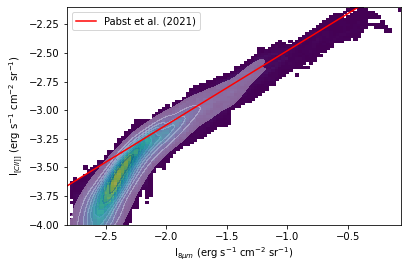

In [6]:
## Compare the 2D histogram with kdeplot results for a random extracted ##

## get a random sample of points from the DataFrame
rand_inds = randint(0, high = len(df.index), size = int(num_randpoints_plot))
temp_df = df.iloc[rand_inds]
temp_8 = temp_df["8 micron"]
temp_CII = temp_df["CII"]

## plotting correlation 8 micron
h = plt.hist2d(df["8 micron"], df["CII"], bins = int((len(df["CII"]))**0.33), cmin = 10)
plt.plot(np.log10(xFit8_Pabst2021),np.log10(yFit8_Pabst2021),'r-',label='Pabst et al. (2021)')

## plot kdeplot
g = sns.kdeplot(temp_8, temp_CII, fill=True,cmap='Blues', alpha=0.4)

plt.ylabel('I$_{[CII]]}$ (erg s$^{-1}$ cm$^{-2}$ sr$^{-1}$)')
plt.xlabel('I$_{8\mu m}$ (erg s$^{-1}$ cm$^{-2}$ sr$^{-1}$)')

#plt.xlim([3e-3, 1e0])
plt.ylim([-4., -2.1])

plt.legend()

#plt.savefig('../plotsCorrelations/Cygnus_CII-8micron.pdf',dpi=300)
plt.show()

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


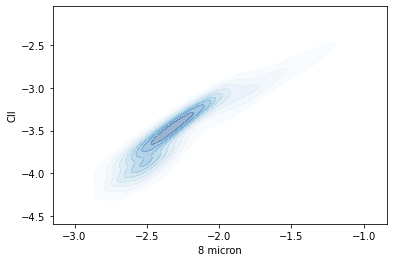

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


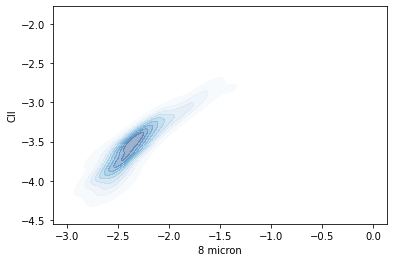

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


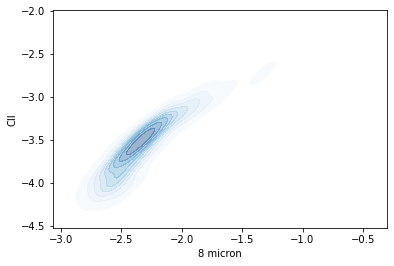

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


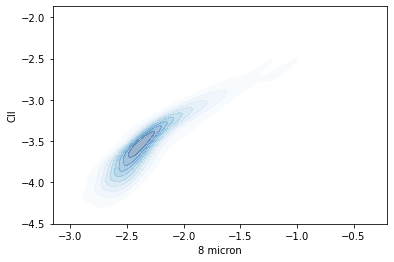

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


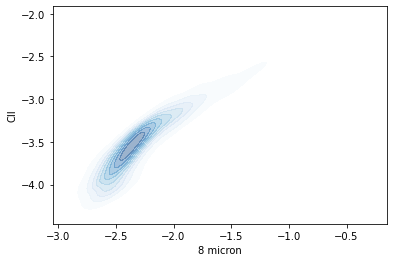

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


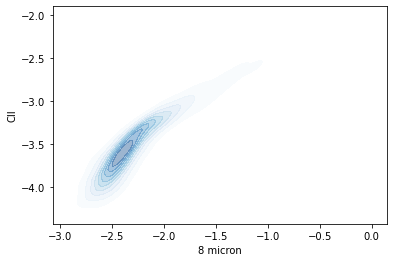

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


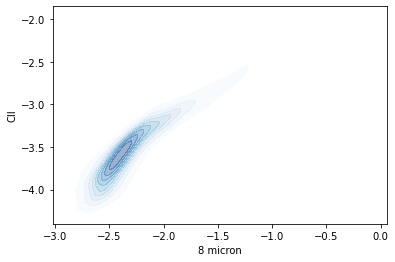

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


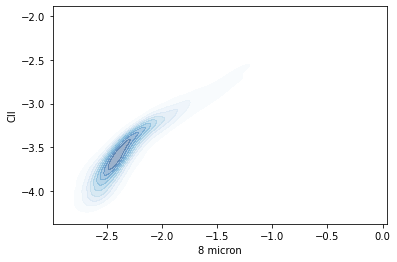

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


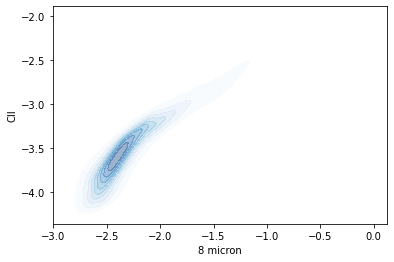

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


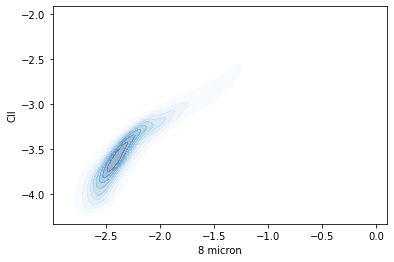

In [7]:
## loop over different sample sizes for the seaborn plotting
times_needed = []
num_points = []
for size in sizes:
    ## get the random indices for the DataFrame
    rand_inds = randint(0, high = len(df.index), size = int(size))
    
    ## get the values
    temp_df = df.iloc[rand_inds]
    temp_8 = temp_df["8 micron"]
    temp_CII = temp_df["CII"]
    
    ## plot kdeplot and keep track of time
    start_time = time.time()
    g = sns.kdeplot(temp_8, temp_CII, fill=True,cmap='Blues', alpha=0.4)
    plt.show()
    end_time = time.time()
    times_needed.append(end_time - start_time)
    num_points.append(int(size))
    

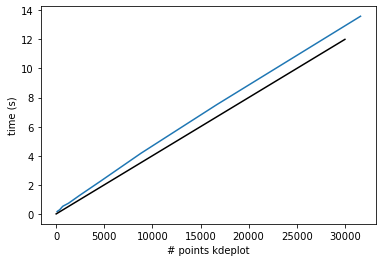

In [8]:
## plot time evolution
plt.plot(num_points, times_needed)
plt.plot([0, 30000], [0, 12], "k-")
plt.ylabel("time (s)")
plt.xlabel("# points kdeplot")
plt.show()

In [9]:
## calculate expected [CII] for G345.88-1.10
"""
Hers70_G345P88 = 1000.  ## MJy/sr
Sp8_G345P88 = 200.  ## MJy/sr

Sp8_G345P88 = 10**6 * 10**-23 * bandWidth8micron*Sp8_G345P88
print(Sp8_G345P88)
CII_70 = 10**-5.1 * Hers70_G345P88**0.57
CII_8 = 10**-1.83 * Sp8_G345P88**0.65
print(CII_70, CII_8)
CII_70 = CII_70/7.0354e-6
CII_8 = CII_8/7.0354e-6
print(CII_70, CII_8)
"""

'\nHers70_G345P88 = 1000.  ## MJy/sr\nSp8_G345P88 = 200.  ## MJy/sr\n\nSp8_G345P88 = 10**6 * 10**-23 * bandWidth8micron*Sp8_G345P88\nprint(Sp8_G345P88)\nCII_70 = 10**-5.1 * Hers70_G345P88**0.57\nCII_8 = 10**-1.83 * Sp8_G345P88**0.65\nprint(CII_70, CII_8)\nCII_70 = CII_70/7.0354e-6\nCII_8 = CII_8/7.0354e-6\nprint(CII_70, CII_8)\n'